# Color Cell IDs

Given an Excel spreadsheet indicating the cell type of each ID, a plot will be made of the tissue cross-section, where each cell type will have a different color.

The Excel spreadsheet must have one cell-type per column. Then each column will indicate the IDs to color. It is ok if different columns have different number of IDs. The column must also indicate the color corresponding to the cell type.

The background in the output figure will be white. Cells whose IDs was not indicated in any column will be colored gray.

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import tifffile as tf
import os

from scipy import ndimage, spatial,stats
viridis = mpl.colormaps['viridis'].resampled(4)

dst = os.pardir + os.sep + 'overlaps' + os.sep
dpi = 125
fs = 13.5
fmt = '.png'
savefigkw = dict(dpi=dpi, format=fmt[1:], bbox_inches='tight')

In [3]:
sample = 'D2'

wsrc = os.pardir + os.sep + 'cell_dams' + os.sep
#csrc = os.pardir + os.sep + 'data' + os.sep
#ksrc = os.pardir + os.sep + 'kde' + os.sep + sample + os.sep

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
label[label == 1] = 0
css = ndimage.find_objects(label)

In [4]:
ksrc = os.pardir + os.sep + 'kde' + os.sep + sample + os.sep
metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 'ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
print(metacell.shape)
metacell.head()

(2937, 19)


,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID,number_nuclei,total_volume,cyto_volume,nuclei_volume
ndimage_cellID,,,,,,,,,,,,,,,,,,,
1,0,17152,0,17152,17152,17152,114911591,36950,114874641,0.999678,7865.12,8160.49,7865.56,8160.76,1,0,4711375231,4709860281,1514950
2,8333,8935,1293,1979,602,686,222903,1351,221552,0.993939,8635.46,1576.65,8635.18,1577.03,2,1,9139023,9083632,55391
3,8893,9151,1317,1598,258,281,42604,0,42604,1.000000,9013.47,1470.26,9013.07,1469.69,3,0,1746764,1746764,0
4,10790,11221,1337,1591,431,254,77463,0,77463,1.000000,10999.04,1460.48,10998.62,1459.99,4,0,3175983,3175983,0
5,7740,8048,1362,1823,308,461,86041,870,85171,0.989889,7894.78,1596.06,7894.19,1595.83,5,1,3527681,3492011,35670


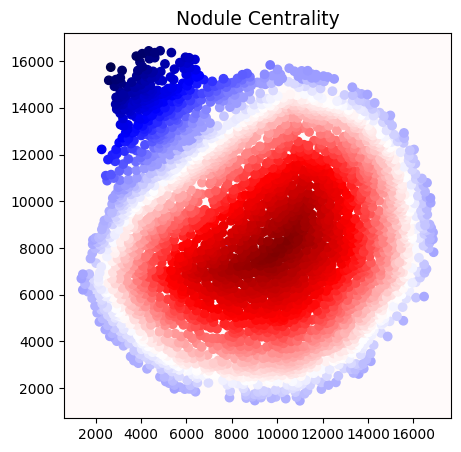

In [15]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(*metacell[['ndimage_comX','ndimage_comY']].T.to_numpy(), c=metaecc['eccentricity'].to_numpy(), cmap='seismic')
ax.set_facecolor('snow')
ax.set_title('Nodule Centrality', fontsize=fs)
plt.savefig(dst + 'centrality' + fmt, **savefigkw);

In [11]:
lzw = tf.imread(wsrc + 'final_edited_LZW.tif')
newarea, _ = np.histogram(lzw.ravel(), bins=np.arange(lzw.max() + 2))
nss = ndimage.find_objects(lzw)
noms = np.flip(np.asarray(ndimage.center_of_mass(lzw, lzw, range(1, lzw.max()+1))), axis=1)
dists = spatial.distance.cdist(noms, metacell[['ndimage_comX','ndimage_comY']],  metric='euclidean')

In [6]:
argmin = np.argmin(dists, axis=1)
argsort = np.argsort(np.min(dists, axis=1))
print(dists.shape, argmin.shape, len(nss), len(css))

i = 2005
ix = argsort[i]
jx = argmin[ix]

(2651, 2937) (2651,) 2651 2937


In [12]:
overlaps = dict()
overdf = pd.DataFrame(0., index=range(1,1+len(nss)), columns=['putative','TP','FP','FN','precision','recall','f1'])

for ix in overdf.index:
    newcell = lzw[nss[ix-1]] == ix
    intersect = label[nss[ix-1]][newcell]
    uq, ct = np.unique(intersect, return_counts=True)
    overlaps[ix] = np.vstack((uq[uq > 0], ct[uq > 0]))
    
    if overlaps[ix].shape[1] > 0:
        
        putative = overlaps[ix][0][ np.argmax(overlaps[ix][1]) ]
        
        overdf.loc[ix, 'putative'] = putative
        overdf.loc[ix, 'TP']  = overlaps[ix][1].max()
        overdf.loc[ix, 'precision'] = overdf.loc[ix, 'TP']/newarea[ix]
        overdf.loc[ix, 'recall'] = overdf.loc[ix, 'TP']/metacell.loc[putative, 'total_area']
        overdf.loc[ix, 'FP'] = newarea[ix] - overdf.loc[ix, 'TP']
        overdf.loc[ix, 'FN'] = metacell.loc[putative, 'total_area'] - overdf.loc[ix, 'TP']

f1 = 2*overdf['precision']*overdf['recall']/(overdf['precision'] + overdf['recall'])
f1 = f1.fillna(0)
overdf['f1'] = f1
overdf = overdf.astype({'putative':int, 'TP':int, 'FP':int, 'FN':int})
overlap = overdf.loc[overdf['putative'] > 0]
overdf

,putative,TP,FP,FN,precision,recall,f1
1,0,0,0,0,0.000000,0.000000,0.000000
2,0,0,0,0,0.000000,0.000000,0.000000
3,3,7314,20928,35290,0.258976,0.171674,0.206476
4,6,2729,41200,80369,0.062123,0.032841,0.042967
5,20,16621,3354,193,0.832090,0.988521,0.903585
...,...,...,...,...,...,...,...
2647,2542,582,0,80472,1.000000,0.007180,0.014258
2648,2542,948,0,80106,1.000000,0.011696,0.023121
2649,2541,862,0,156372,1.000000,0.005482,0.010905
2650,2542,1075,49,79979,0.956406,0.013263,0.026163


In [127]:
print(len(nss), len(css), len(overdf[overdf['putative'] == 0]))

2651 2937 48


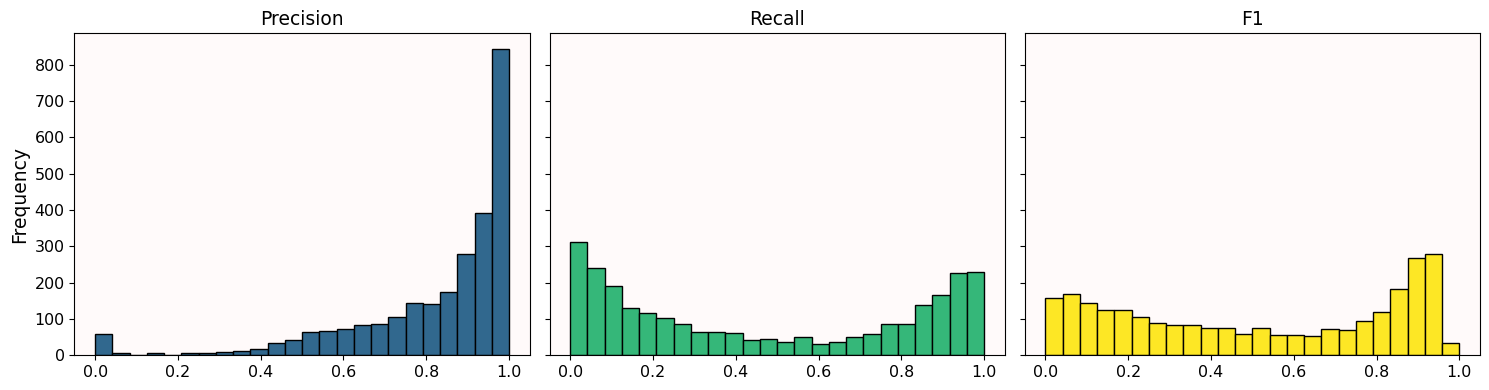

In [16]:
bins = np.linspace(0,1,25)
fig,ax = plt.subplots(1,3,figsize=(15,4), sharex=True, sharey=True)
for i,c in enumerate(['precision', 'recall', 'f1']):
    ax[i].set_facecolor('snow')
    ax[i].set_title(c.title(), fontsize=fs)
    ax[i].hist(overdf[c], color=viridis(i+1), bins=bins, edgecolor='k')
    ax[i].tick_params(labelsize=0.85*fs)
ax[0].set_ylabel('Frequency', fontsize=fs)
fig.tight_layout()
plt.savefig(dst + 'value_distribution' + fmt, **savefigkw)

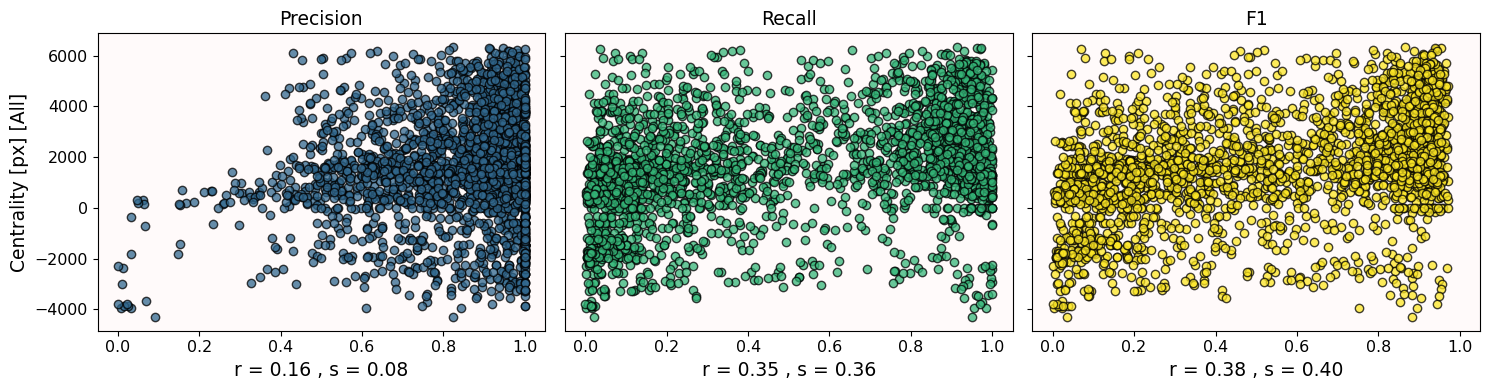

In [17]:
fig,ax = plt.subplots(1,3,figsize=(15,4), sharex=True, sharey=True)
yval = metaecc.loc[overlap['putative'].to_numpy(), 'eccentricity']
for i,c in enumerate(['precision', 'recall', 'f1']):
    pearson = stats.pearsonr(overlap[c], yval)
    spearman = stats.spearmanr(overlap[c], yval)

    ax[i].set_facecolor('snow')
    ax[i].set_title(c.title(), fontsize=fs)
    ax[i].scatter(overlap[c], yval, color=viridis(i+1), edgecolor='k', alpha=0.75)
    ax[i].tick_params(labelsize=0.85*fs)
    ax[i].set_xlabel('r = {:.2f} , s = {:.2f}'.format(pearson.statistic, spearman.statistic), fontsize=fs)
ax[0].set_ylabel('Centrality [px] [All]', fontsize=fs)
fig.tight_layout()
plt.savefig(dst + 'allcentrality' + fmt, **savefigkw)

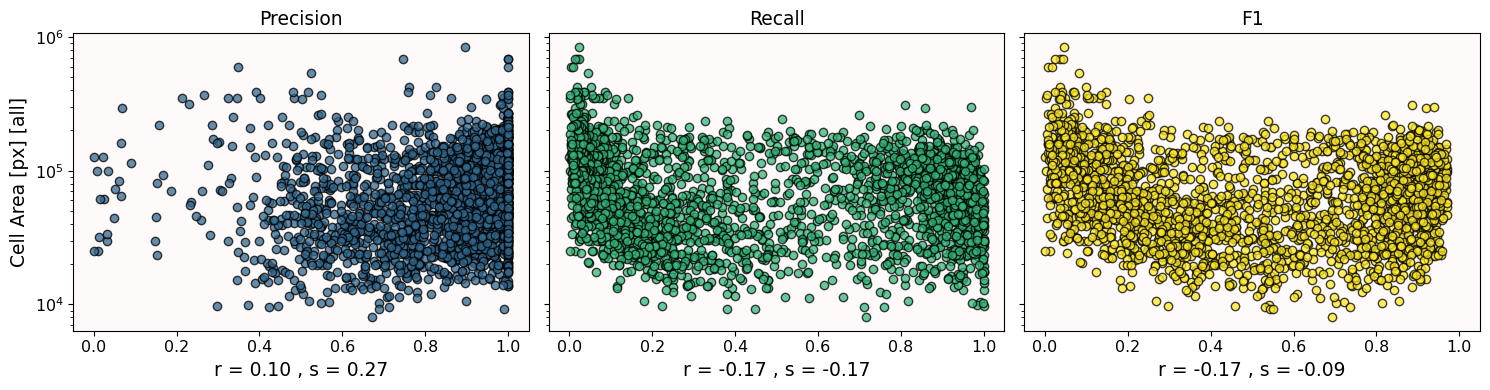

In [18]:
yval = metacell.loc[overlap['putative'].to_numpy(), 'total_area']
fig,ax = plt.subplots(1,3,figsize=(15,4), sharex=True, sharey=True)

for i,c in enumerate(['precision', 'recall', 'f1']):
    pearson = stats.pearsonr(overlap[c], yval)
    spearman = stats.spearmanr(overlap[c], yval)

    ax[i].set_facecolor('snow')
    ax[i].set_title(c.title(), fontsize=fs)
    ax[i].scatter(overlap[c], yval, color=viridis(i+1), edgecolor='k', alpha=0.75)
    ax[i].tick_params(labelsize=0.85*fs)
    ax[i].set_yscale('log',base=10)
    ax[i].set_xlabel('r = {:.2f} , s = {:.2f}'.format(pearson.statistic, spearman.statistic), fontsize=fs)
ax[0].set_ylabel('Cell Area [px] [all]', fontsize=fs)
fig.tight_layout()
plt.savefig(dst + 'allarea' + fmt, **savefigkw)

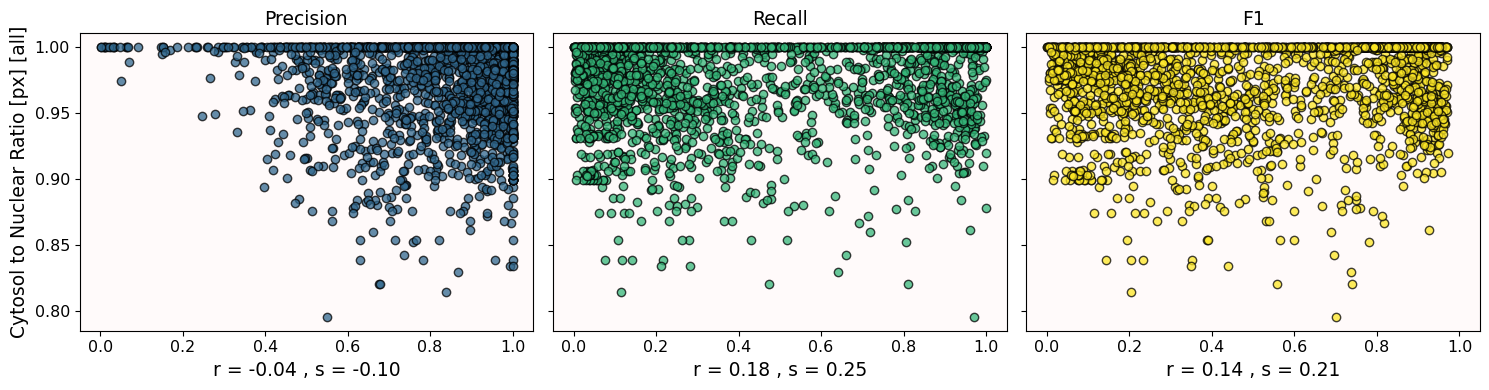

In [19]:
yval = metacell.loc[overlap['putative'].to_numpy(), 'c2t_area_ratio']
fig,ax = plt.subplots(1,3,figsize=(15,4), sharex=True, sharey=True)

for i,c in enumerate(['precision', 'recall', 'f1']):
    pearson = stats.pearsonr(overlap[c], yval)
    spearman = stats.spearmanr(overlap[c], yval)

    ax[i].set_facecolor('snow')
    ax[i].set_title(c.title(), fontsize=fs)
    ax[i].scatter(overlap[c], yval, color=viridis(i+1), edgecolor='k', alpha=0.75)
    ax[i].tick_params(labelsize=0.85*fs)
    #ax[i].set_yscale('log',base=10)
    ax[i].set_xlabel('r = {:.2f} , s = {:.2f}'.format(pearson.statistic, spearman.statistic), fontsize=fs)
ax[0].set_ylabel('Cytosol to Nuclear Ratio [px] [all]', fontsize=fs)
fig.tight_layout()

plt.savefig(dst + 'allc2nratio' + fmt, **savefigkw)

In [20]:
nuccell = list(set(metacell[metacell['number_nuclei'] == 1].index) & set(overlap['putative']))
print(len(nuccell))
yaohua = []
for n in nuccell:
    yaohua.append(overlap[overlap['putative'] == n].index.values)
yaohua = np.hstack(yaohua)
print(len(yaohua))

nuc = overlap.loc[yaohua, 'putative'].to_numpy()

766
994


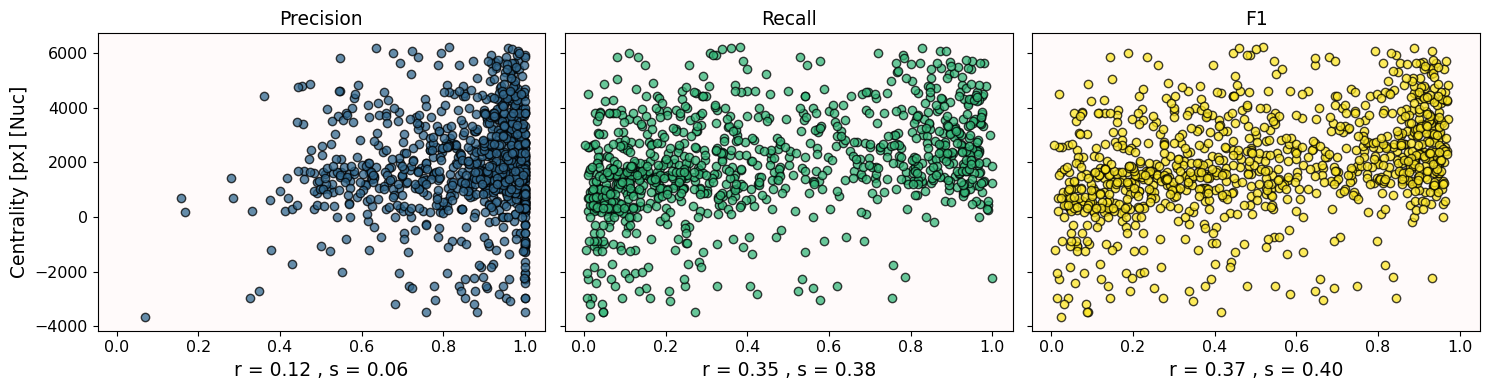

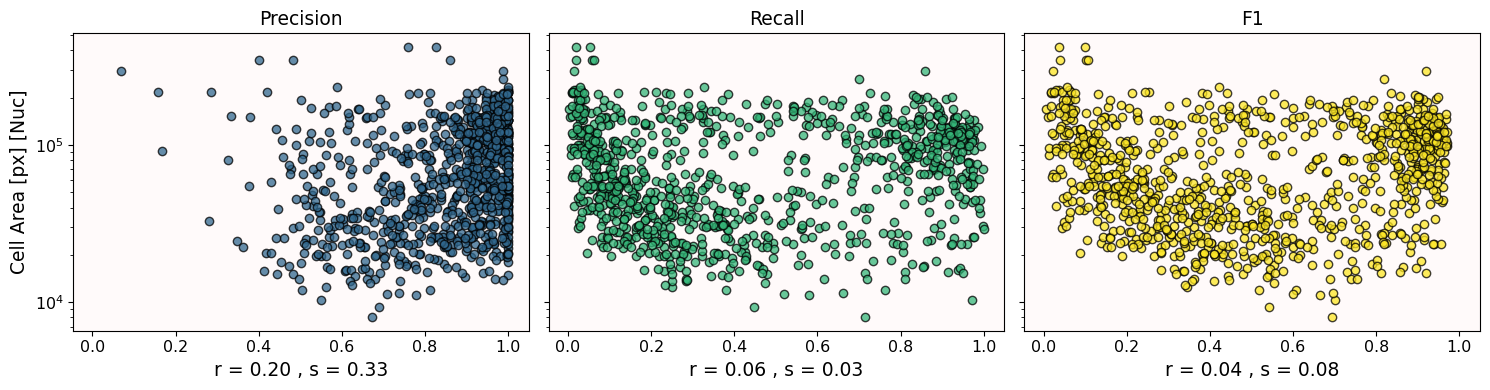

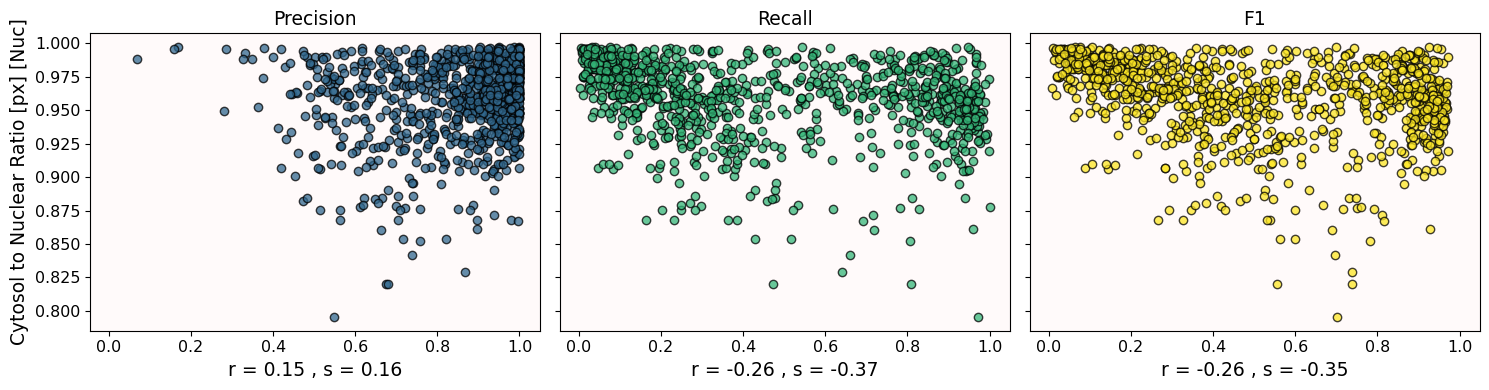

In [21]:
fig,ax = plt.subplots(1,3,figsize=(15,4), sharex=True, sharey=True)
yval = metaecc.loc[nuc, 'eccentricity']
for i,c in enumerate(['precision', 'recall', 'f1']):
    pearson = stats.pearsonr(overlap.loc[yaohua, c], yval)
    spearman = stats.spearmanr(overlap.loc[yaohua, c], yval)

    ax[i].set_facecolor('snow')
    ax[i].set_title(c.title(), fontsize=fs)
    ax[i].scatter(overlap.loc[yaohua, c], yval, color=viridis(i+1), edgecolor='k', alpha=0.75)
    ax[i].tick_params(labelsize=0.85*fs)
    ax[i].set_xlabel('r = {:.2f} , s = {:.2f}'.format(pearson.statistic, spearman.statistic), fontsize=fs)
ax[0].set_ylabel('Centrality [px] [Nuc]', fontsize=fs)
fig.tight_layout()
plt.savefig(dst + 'nuccentrality' + fmt, **savefigkw)

yval = metacell.loc[nuc, 'total_area']
fig,ax = plt.subplots(1,3,figsize=(15,4), sharex=True, sharey=True)

for i,c in enumerate(['precision', 'recall', 'f1']):
    pearson = stats.pearsonr(overlap.loc[yaohua, c], yval)
    spearman = stats.spearmanr(overlap.loc[yaohua, c], yval)

    ax[i].set_facecolor('snow')
    ax[i].set_title(c.title(), fontsize=fs)
    ax[i].scatter(overlap.loc[yaohua, c], yval, color=viridis(i+1), edgecolor='k', alpha=0.75)
    ax[i].tick_params(labelsize=0.85*fs)
    ax[i].set_yscale('log',base=10)
    ax[i].set_xlabel('r = {:.2f} , s = {:.2f}'.format(pearson.statistic, spearman.statistic), fontsize=fs)
ax[0].set_ylabel('Cell Area [px] [Nuc]', fontsize=fs)
fig.tight_layout()
plt.savefig(dst + 'nucarea' + fmt, **savefigkw)

yval = metacell.loc[nuc, 'c2t_area_ratio']
fig,ax = plt.subplots(1,3,figsize=(15,4), sharex=True, sharey=True)

for i,c in enumerate(['precision', 'recall', 'f1']):
    pearson = stats.pearsonr(overlap.loc[yaohua, c], yval)
    spearman = stats.spearmanr(overlap.loc[yaohua, c], yval)

    ax[i].set_facecolor('snow')
    ax[i].set_title(c.title(), fontsize=fs)
    ax[i].scatter(overlap.loc[yaohua, c], yval, color=viridis(i+1), edgecolor='k', alpha=0.75)
    ax[i].tick_params(labelsize=0.85*fs)
    #ax[i].set_yscale('log',base=10)
    ax[i].set_xlabel('r = {:.2f} , s = {:.2f}'.format(pearson.statistic, spearman.statistic), fontsize=fs)
ax[0].set_ylabel('Cytosol to Nuclear Ratio [px] [Nuc]', fontsize=fs)
fig.tight_layout()
plt.savefig(dst + 'nucc2nratio' + fmt, **savefigkw)

In [108]:
overlap.sort_values(by='f1').iloc[2000:2010]

,putative,TP,FP,FN,precision,recall,f1
285,730,16994,529,4520,0.969811,0.789904,0.870661
107,407,63355,12936,5884,0.830439,0.915019,0.870680
93,356,59441,11815,5783,0.834189,0.911336,0.871058
1336,2828,31570,3793,5525,0.892741,0.851058,0.871401
1021,2172,17756,1167,4071,0.938329,0.813488,0.871460
146,473,19642,5707,72,0.774863,0.996348,0.871757
1019,2170,47416,12804,1143,0.787380,0.976462,0.871786
780,1641,49169,2295,12160,0.955406,0.801725,0.871845
186,550,40811,5867,6108,0.874309,0.869818,0.872058
1394,2925,86870,7411,18034,0.921395,0.828090,0.872254


In [117]:
ix = 107
print(newarea[ix], overlaps[ix], sep='\t')
if overlaps[ix].shape[1] > 0:
    print( np.round(100*overlaps[ix][1]/newarea[ix],1) )
    jx = overlaps[ix][0][ np.argmax(overlaps[ix][1]) ]
else:
    print(0.0)
ix -= 1; jx -= 1

76291	[[  363   369   376   407   410   428   439]
 [    3   751  3303 63355  6502   974   755]]
[ 0.   1.   4.3 83.   8.5  1.3  1. ]


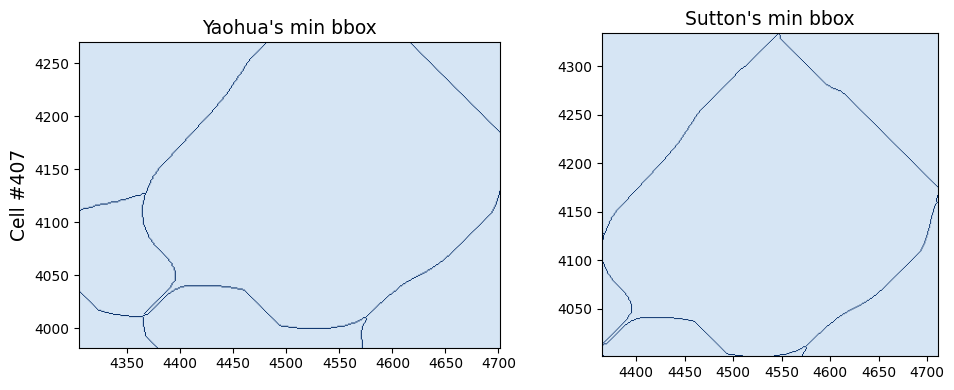

In [118]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].set_ylabel('Cell #{}'.format(jx+1), fontsize=fs)

extent = (nss[ix][1].start, nss[ix][1].stop, nss[ix][0].start, nss[ix][0].stop)
ax[0].imshow(label[nss[ix]] > 0, origin='lower', extent=extent, cmap='Blues_r', vmax=1.2, vmin=0)

extent = (css[jx][1].start, css[jx][1].stop, css[jx][0].start, css[jx][0].stop)
ax[1].imshow(label[css[jx]] > 0, origin='lower', extent=extent, cmap='Blues_r', vmax=1.2, vmin=0)

title = ["Yaohua's min bbox", "Sutton's min bbox"]
for i in range(len(ax)):
    ax[i].set_title(title[i], fontsize=fs)

fig.tight_layout()
plt.savefig(dst+'altcell_{:04d}'.format(jx+1)+fmt, **savefigkw)

In [119]:
print(ix, jx)

print(css[jx], nss[ix], sep='\t')
js_ = np.s_[min([nss[ix][0].start, css[jx][0].start]) : max([nss[ix][0].stop, css[jx][0].stop]) ,
            min([nss[ix][1].start, css[jx][1].start]) : max([nss[ix][1].stop, css[jx][1].stop]) ]

gts_ = np.s_[css[jx][0].start - js_[0].start : css[jx][0].stop - js_[0].start, 
             css[jx][1].start - js_[1].start : css[jx][1].stop - js_[1].start]

news_= np.s_[nss[ix][0].start - js_[0].start : nss[ix][0].stop - js_[0].start, 
             nss[ix][1].start - js_[1].start : nss[ix][1].stop - js_[1].start]

print('--', js_, news_, gts_, sep='\n')

nwjoint = np.zeros(lzw[js_].shape, dtype=int)
gtjoint = np.zeros(lzw[js_].shape, dtype=int)
nwjoint[news_] += 1*(lzw[nss[ix]] == ix+1)
gtjoint[gts_]  += 2*(label[css[jx]] == jx+1)

106 406
(slice(4001, 4334, None), slice(4365, 4711, None))	(slice(3982, 4270, None), slice(4305, 4701, None))
--
(slice(3982, 4334, None), slice(4305, 4711, None))
(slice(0, 288, None), slice(0, 396, None))
(slice(19, 352, None), slice(60, 406, None))


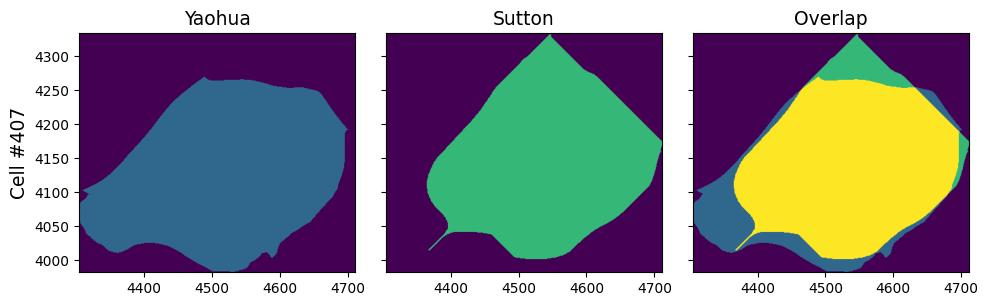

In [120]:
extent = (js_[1].start, js_[1].stop, js_[0].start, js_[0].stop)

fig, ax = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
ax[0].set_ylabel('Cell #{}'.format(jx+1), fontsize=fs)
ax[0].imshow(nwjoint, vmin=0, vmax=3, origin='lower', extent=extent)
ax[1].imshow(gtjoint, vmin=0, vmax=3, origin='lower', extent=extent);
ax[2].imshow(nwjoint + gtjoint, vmin=0, vmax=3, origin='lower', extent=extent);
title = ['Yaohua', 'Sutton', 'Overlap']
for i in range(len(ax)):
    ax[i].set_title(title[i], fontsize=fs)

fig.tight_layout()
plt.savefig(dst+'cell_{:04d}'.format(jx+1)+fmt, **savefigkw)

In [9]:
uq = np.unique(lzw.ravel())
print(len(uq), uq[:10], uq[-10:], sep='\n')

2652
[0 1 2 3 4 5 6 7 8 9]
[2642 2643 2644 2645 2646 2647 2648 2649 2650 2651]


In [124]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(lzw, origin='lower')
ax[1].imshow(label, origin='lower')

title = ['Yaohua', 'Sutton']
for i in range(len(ax)):
    ax[i].set_title(title[i], fontsize=fs)
fig.tight_layout();
plt.savefig(dst+'sutton_vs_yaohua'+fmt, format=fmt[1:], dpi=250, bbox_inches='tight')
plt.close()